# DTSA 5511: Introduction to Deep Learning - Final Project

## Overview, Purpose, and Data  

### Overview 

For this project, I will be looking at a set of tweets taken from Twitter and attempt to classify the Myer-Briggs Type Indicator (MBTI) of that individual. This expands on the work we did in Week 4, taking it from binary classification problem to a multi-class classification problem.  

A quick summary of the [MBTI](https://www.myersbriggs.org/my-mbti-personality-type/mbti-basics/) is that it is a personality inventory that attempts to provide an approachable concept to the theory of personality types. You are assigned a 4 letter personality type where each of the letters stands for something listed below. There are 16 combinations of letters equating to 16 personality types. Admittedly, I am unaware if MBTI is strongly backed by scientific research, so this exploration should be treated more as a learning exercise instead of rigorous explanation.

* Introversion/Extraversion: The first dimension is connected to the person's energy. Extroverts prefer to put their energy into dealing with people, circumstances, or the outer world. Introverts prefer to focus their energies on dealing with ideas, facts, explanations, or beliefs, or the inner world.
* iNtuition /Sensing: The second dimension is about how information is processed. Sensing is the type of person who wants to look at facts, with what is known. A person with iNtuition tends to experiment with ideas, investigate the unknown.
* Feeling /Thinking: The third dimension is related to decision making. Thinking people make decisions based on objective reasoning and an independent perspective. The type of people who prefer to use values is Feeling.
* Perception /Judgement: The final dimension is related to the way of life chosen. Judgment is the type of person that prefers to have their lives planned and structured. Perception is the type of person that prefers to go with the flow, to be adaptable, and to respond to events as they occur.  

As for the uses of the model I will seek to create, it certainly does not have the impact of say a model determining if a disaster is occurring or whether a disease is detected. However, it could be used by social media websites to generate engagement or even, depending on how scientifically backed MBTI is, protentially provide an insight into their mental health.

### Data Source  

Data for this project was obtained from the [Kaggle MBTI Personality Type Dataset](https://www.kaggle.com/datasets/mazlumi/mbti-personality-type-twitter-dataset) provided by user IBRAHIMMAZLUM.  

### Setup and Data Import Tasks

In [19]:
# Initial Setup Steps
# Import Libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import SimpleRNN, Dense, TextVectorization 
from tensorflow.keras.layers import Embedding, GRU, LSTM
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam

In [2]:
# Data import into dataframes, note data set leverages '|||' as separator
tweet_df = pd.read_csv("./Data/twitter_MBTI.csv")
tweet_list = []
tweet_lable_list = []
for tweets, label in zip(tweet_df.text, tweet_df.label):
    for tweet in tweets.split("|||"):
        tweet_list.append(tweet)
        tweet_lable_list.append(label)
tweet_df = pd.DataFrame({"text": tweet_list, "label": tweet_lable_list})

In [3]:
tweet_df = tweet_df[tweet_df.text.str.split(' ').map(len) > 10]
tweet_df = tweet_df[tweet_df.text.str.split(' ').map(len) < 50]
tweet_df.reset_index(inplace=True, drop=True)
tweet_df = tweet_df.iloc[np.random.choice(tweet_df.shape[0], 100000, replace=False)]

In [29]:
# View first several rows of imported data
tweet_df.tail()

,text,label
316470,@gddaengit Tell me this dialogue wouldn’t soun...,enfp
192226,!s4 vol2 spoilers\n\ngod i dont even wanna fin...,entp
154865,Funfact about me is that everytime i have a bl...,infj
169277,"wtb lfs ph 😞 preferrably from 1 seller only, f...",enfp
260367,good night mga ferson priv ko muna toh kase ma...,estj


In [5]:
# View shape and type of imported data
print(f"The data set contains {tweet_df.shape[0]} samples.")
print(f"We are provided the following information: {', '.join(tweet_df.columns)}")
print("Data types are as follows:")
print(tweet_df.dtypes)

The data set contains 100000 samples.
We are provided the following information: text, label
Data types are as follows:
text     object
label    object
dtype: object


## Exploratory Data Analysis  

### Disctribution of Classes  

For this project we are looking to group participants in to one of 16 classes. Our data contains a label titled **lable** indicating which of the 16 personality types the user belonged to. Let us look at a distribution of these classes.

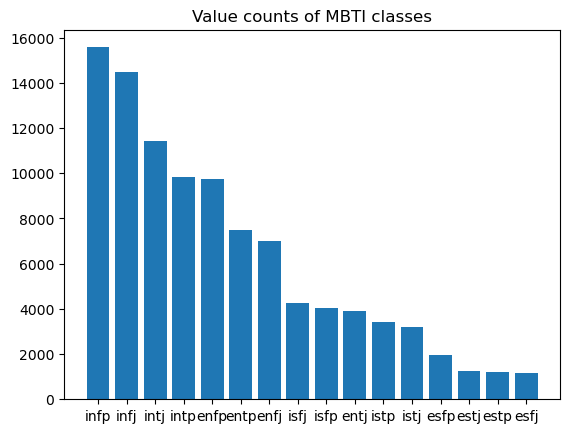

In [6]:
# Distribution of classes - bar chart
MBTI_vals = tweet_df.label.value_counts()
plt.bar(MBTI_vals.index, MBTI_vals.values)
plt.title("Value counts of MBTI classes")
plt.show()

In [7]:
# Table of counts
for cat, count in zip(MBTI_vals.index, MBTI_vals.values):
    print(f"{cat} -> {count}")

infp -> 15576
infj -> 14482
intj -> 11435
intp -> 9848
enfp -> 9767
entp -> 7477
enfj -> 7018
isfj -> 4255
isfp -> 4051
entj -> 3906
istp -> 3400
istj -> 3220
esfp -> 1940
estj -> 1235
estp -> 1208
esfj -> 1182


Next we will take a look at the length of tweets. This will not be 100% accuract as we have yet to do any cleaning, however it should give us an idea of the data we are working with.

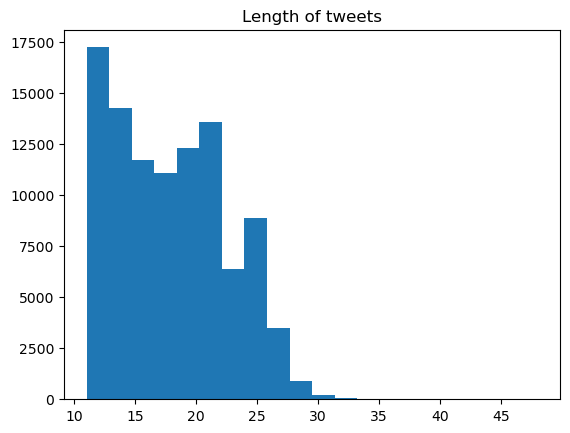

Longest tweet length: 48.
Shortest tweet length: 11.


In [8]:
# Length of tweets - histogram
len_of_tweets = list(map(len, tweet_df.text.str.split(' ')))
plt.hist(len_of_tweets, bins=20)
plt.title('Length of tweets')
plt.show()
print(f"Longest tweet length: {max(len_of_tweets)}.")
print(f"Shortest tweet length: {min(len_of_tweets)}.")

### Cleaning and Preprocessing  

I already removed tweets with a word length of less than 10 when sizing the data.

Most of the rest of the cleaning of our actual data will be done in-line in the models by a TextVectorization layer. This will strip out whitespaces, punctionation as well as standardize word case.  We do have several tweets that are of zero length which we will remove.

A couple points of note about our data. First off, there are a small percentage of samples that are not in English. In this case, to avoid a lengthy exercise in filtering out tweets I will leave them in. However, an area of improvement may be better engineering of the data.  

This does lead to a greater conversation about this data source. The dataset does not dive too deep into the data gathering method. On top of this, the actual MBTI labels were self-identified. This once again leads us to the idea that we are performing this analysis as an exercise in learning, not to get a rigorous model that could be applied broadly.  

In [10]:
# Convert string label to number
MBTI_cat = ['infp',
 'infj',
 'intp',
 'intj',
 'enfp',
 'entp',
 'enfj',
 'isfj',
 'isfp',
 'istp',
 'entj',
 'istj',
 'esfp',
 'esfj',
 'estp',
 'estj']
MBTI_index = range(0,16)

MBTI_cat_to_index = {c:i for c,i in zip(MBTI_cat, MBTI_index)}
MBTI_index_to_cat = {i:c for c,i in zip(MBTI_cat, MBTI_index)}

In [9]:
targets = pd.get_dummies(tweet_df.label).values

### Preprocessing and GloVe  

In the week 4 assignment, I used the GloVe encoding method and saw fairly good results. As such, I will be sticking with this approach as I explore more advanced models in this use case. A quick summary of GloVe and NLP follows.  

In order to perform analysis on text, we first have to turn it in to a vector by tokenizing it. This will transform it into a numerical representation. While this will allow us to directly compare whether two tweets are similar by looking for the same words, it won't allow us to compare similarity by comparing similar words, like cat and tiger. This is where GloVe comes in.  

GloVe is a word vector technique that compares sequences of words with pre-trained statistics to determine how similar words are. What is unique about GloVe is that instead of comparing against the local sample that you have, you can compare word vectors against vectors trained on large samples of text. This will generally give you a broader representation, though of note, if your samples are fairly unique, you may lose some of the ability to detect that specificity.

In [11]:
# Text vectorization and list of vocabulary
text_vectorization = TextVectorization(
    max_tokens=5000,
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    output_mode="int",
    output_sequence_length=max(len_of_tweets)
)

text_vectorization.adapt(tweet_df.text)

# Create a vocabulary dictionary which maps words to integer values
vocab_dict = {key:val for key,val in zip(text_vectorization.get_vocabulary(), range(len(text_vectorization.get_vocabulary())))}

print(list(vocab_dict.items())[:10])

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-04-29 11:06:44.653771: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-29 11:06:44.653930: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-04-29 11:06:44.702947: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-29 11:06:44.736935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[('', 0), ('[UNK]', 1), ('i', 2), ('the', 3), ('to', 4), ('a', 5), ('and', 6), ('my', 7), ('is', 8), ('of', 9)]


In [12]:
# GloVe Embedding
glove_path = "./glove.6B/glove.6B.200d.txt"
glove_dict = {}
with open(glove_path) as f:
    for line in f:
        vals = line.split()
        word = vals[0]
        coefs = vals[1:]
        glove_dict[word] = np.asarray(coefs, dtype="float32")

embedding_matrix = np.zeros(shape=(len(vocab_dict)+1, 200))
for word, index in vocab_dict.items():
    embedding_vector = glove_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

## Architecture and Modeling

In week 4, I found fairly performant results using a stacked Long Short-Term Memory (LSTM) model. During my reading on the subject, I found reference to using something called a Transformer model or architecture that I want to compare against.

Transformer architecture relies on the idea of self-attention which looks at an entire input, or in this case tweet, and attempts to discern what the significance of each part of the input is. Transfomers can be leveraged in similar applications to RNN models we learned about in class, but this idea of looking at the whole input separates them and allows them to work with greater parallelization than RNN models. Those familiar with ChatGPT might be interested to know that this model employes Transformer models given with many other architectures used in combination.

In this project, I will attempt to compare the stacked LTSM model from week four against this more advanced model and get an idea of what performs better. I will be looking at actual accuracy performance as well run-time to train.

One important note is that since I am switching from a binary class classification model to a multi-class classification model, the activiation functions of the output will need to swap from "sigmoid" to "softmax". I am also swapping the loss function from binary cross entropy to categorical cross entropy.

### Model 1: Stacked (x3) LSTM Model

In [13]:
# Stacked LTSM
model_LSTMx3 = Sequential()
model_LSTMx3.add(keras.Input(shape=(1,), dtype=tf.string))
model_LSTMx3.add(text_vectorization)
model_LSTMx3.add(Embedding(
    input_dim=len(vocab_dict)+1,
    output_dim=200,
    embeddings_initializer=Constant(embedding_matrix),
    trainable=False
))
model_LSTMx3.add(keras.layers.LSTM(units=128, return_sequences=True, dropout=0.1))
model_LSTMx3.add(keras.layers.LSTM(units=128, return_sequences=True, dropout=0.1))
model_LSTMx3.add(keras.layers.LSTM(units=128, return_sequences=False))
model_LSTMx3.add(Dense(16, activation='softmax'))
model_LSTMx3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 48)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 48, 200)           1000200   
                                                                 
 lstm (LSTM)                 (None, 48, 128)           168448    
                                                                 
 lstm_1 (LSTM)               (None, 48, 128)           131584    
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                        

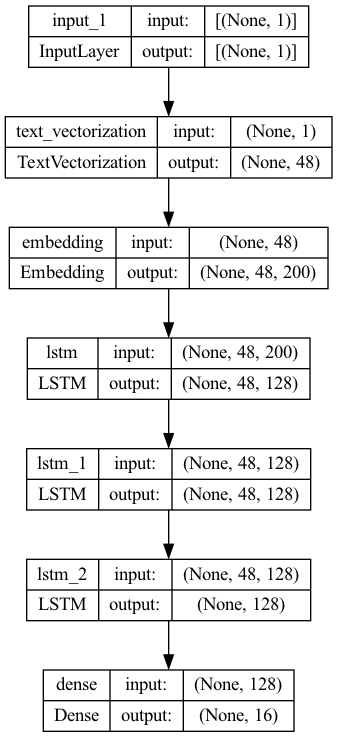

In [14]:
keras.utils.plot_model(model_LSTMx3, show_shapes=True)

In [15]:
# Compile and fit stacked_LSTM_results
model_LSTMx3.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"]
)

stacked_LSTM_results = model_LSTMx3.fit(tweet_df.text, targets, validation_split=0.2, epochs=5)

Epoch 1/5


2023-04-29 11:07:06.917864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-29 11:07:07.308114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-29 11:07:07.496423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-29 11:07:07.590413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-29 11:07:07.726837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-29 11:07:07.972747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-29 11:07:08.140566: I tensorflow/core/grappler/optimizers/cust

2499/2500 [============================>.] - ETA: 0s - loss: 2.5116 - accuracy: 0.1520

2023-04-29 11:08:57.726916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-29 11:08:57.870218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-29 11:08:57.960962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-29 11:08:58.046185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2500/2500 [==============================] - 128s 50ms/step - loss: 2.5116 - accuracy: 0.1520 - val_loss: 2.5119 - val_accuracy: 0.1479
Epoch 2/5
2500/2500 [==============================] - 125s 50ms/step - loss: 2.5069 - accuracy: 0.1561 - val_loss: 2.5104 - val_accuracy: 0.1536
Epoch 3/5
2500/2500 [==============================] - 127s 51ms/step - loss: 2.5070 - accuracy: 0.1575 - val_loss: 2.5092 - val_accuracy: 0.1622
Epoch 4/5
2500/2500 [==============================] - 129s 51ms/step - loss: 2.5054 - accuracy: 0.1588 - val_loss: 2.5087 - val_accuracy: 0.1564
Epoch 5/5
2500/2500 [==============================] - 127s 51ms/step - loss: 2.5016 - accuracy: 0.1627 - val_loss: 2.5045 - val_accuracy: 0.1649


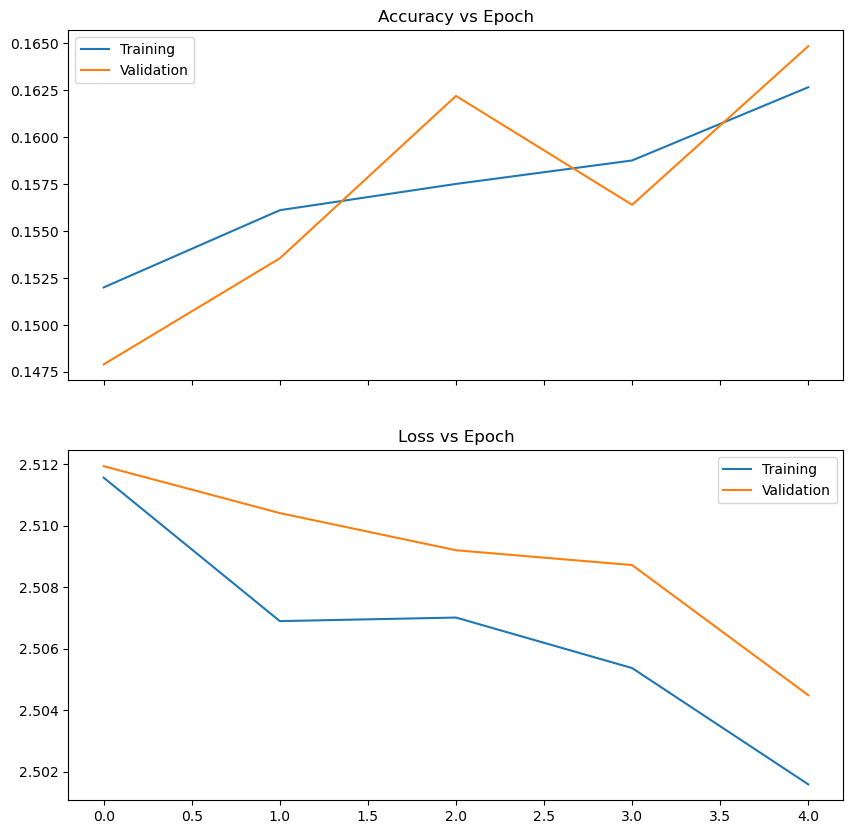

In [16]:
# Model evaluation graphs
fig = plt.figure(figsize=(10,10))
axes = fig.subplots(nrows=2, ncols=1, sharex=True)
axes[0].plot(stacked_LSTM_results.history['accuracy'])
axes[0].plot(stacked_LSTM_results.history['val_accuracy'])
#axes[0].set_ylim([0,1.])
axes[0].legend(["Training", "Validation"])
axes[0].set_title("Accuracy vs Epoch")

axes[1].plot(stacked_LSTM_results.history['loss'])
axes[1].plot(stacked_LSTM_results.history['val_loss'])
#axes[1].set_ylim([0,1.])
axes[1].legend(["Training", "Validation"])
axes[1].set_title("Loss vs Epoch")

plt.show()

#### Results and Analysis for Stacked LTSM

As we can see, the final accuracy results are not great for this model. On the one hand, they are significantly better than a complete guess (which we would expect to have a 1/16 ~ 6% chance of being correct). However this is not good enough where you would want to put much trust behind the predictions of this model.  

One note, we can see that the accuracy is still increasing from this model and the loss is decreasing. I will explore this further in hyperparameter tuning to see if we can get even better results.

| Type | Final Accuracy |
|---|---|
| Training | 0.1627 |
| Validation | 0.1649 |  

### Model 2: Transformer Layers Model

In [20]:
# Class taken from Deep Learning with Python Second Edition by Francois Chollet
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)
  
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

In [21]:
# Transformer Model
model_transformer = keras.Sequential()
model_transformer.add(keras.Input(shape=(1,), dtype=tf.string))
model_transformer.add(text_vectorization)
model_transformer.add(Embedding(
    input_dim=len(vocab_dict)+1,
    output_dim=200,
    embeddings_initializer=Constant(embedding_matrix),
    trainable=False
))
model_transformer.add(TransformerEncoder(200, 128, 2))
model_transformer.add(layers.GlobalMaxPooling1D())
model_transformer.add(layers.Dropout(0.5))
model_transformer.add(Dense(units=16, activation="softmax"))
model_transformer.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 48)               0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 48, 200)           1000200   
                                                                 
 transformer_encoder (Transf  (None, 48, 200)          373728    
 ormerEncoder)                                                   
                                                                 
 global_max_pooling1d (Globa  (None, 200)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                      

In [22]:
# Compile and fit stacked_LSTM_results
model_transformer.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"]
)

transformer_res = model_transformer.fit(tweet_df.text, targets, validation_split=0.2, epochs=5)

Epoch 1/5


2023-04-29 16:19:10.638404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2500/2500 [==============================] - ETA: 0s - loss: 2.5723 - accuracy: 0.1468

2023-04-29 16:20:54.835916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2500/2500 [==============================] - 119s 47ms/step - loss: 2.5723 - accuracy: 0.1468 - val_loss: 2.5059 - val_accuracy: 0.1644
Epoch 2/5
2500/2500 [==============================] - 120s 48ms/step - loss: 2.5082 - accuracy: 0.1605 - val_loss: 2.4961 - val_accuracy: 0.1619
Epoch 3/5
2500/2500 [==============================] - 122s 49ms/step - loss: 2.4962 - accuracy: 0.1668 - val_loss: 2.4981 - val_accuracy: 0.1657
Epoch 4/5
2500/2500 [==============================] - 124s 50ms/step - loss: 2.4900 - accuracy: 0.1683 - val_loss: 2.4930 - val_accuracy: 0.1657
Epoch 5/5
2500/2500 [==============================] - 124s 50ms/step - loss: 2.4841 - accuracy: 0.1729 - val_loss: 2.4891 - val_accuracy: 0.1701


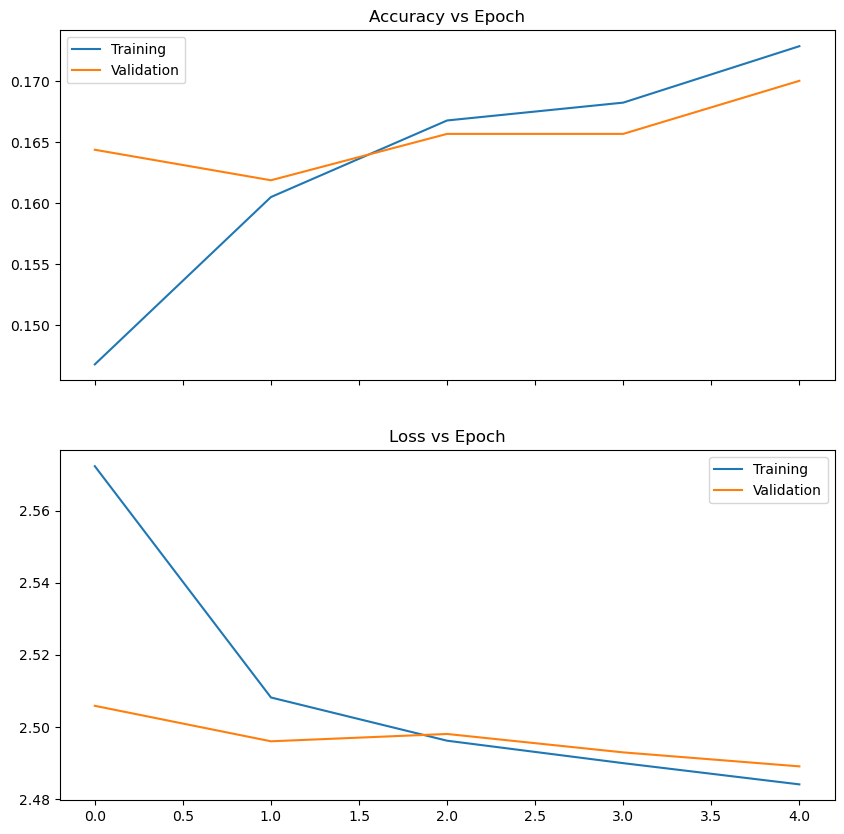

In [23]:
# Model evaluation graphs
fig = plt.figure(figsize=(10,10))
axes = fig.subplots(nrows=2, ncols=1, sharex=True)
axes[0].plot(transformer_res.history['accuracy'])
axes[0].plot(transformer_res.history['val_accuracy'])
#axes[0].set_ylim([0,1.])
axes[0].legend(["Training", "Validation"])
axes[0].set_title("Accuracy vs Epoch")

axes[1].plot(transformer_res.history['loss'])
axes[1].plot(transformer_res.history['val_loss'])
#axes[1].set_ylim([0,1.])
axes[1].legend(["Training", "Validation"])
axes[1].set_title("Loss vs Epoch")

plt.show()

#### Results and Analysis for Transformer Model

Utilizing the transformer model architecture we do see a marginal improvement in accuracy, jumping from 0.16 in our stacked LSTM model to 0.17 in our transformer model. This still is not great results which may be an indicator that the models are performing as well as they can and in fact we can't make very accurate predictions of MBTI based on individual tweets.

We do still notice that accuracy was increasing so I will bump up learning rate and epochs a little bit when doing hyperparameter tuning.

| Type | Final Accuracy |
|---|---|
| Training | 0.1729 |
| Validation | 0.1701 |  

### Hyperparameter Tuning: Epochs  

In our testing, we saw that accuracy was still increasing (and loss decreasing) as we were training our model. I'm going to make a couple of modifications to our training model and run it our to 12 epochs to see if we can get a plateau.

In [26]:
# Transformer Model
model_tuning = keras.Sequential()
model_tuning.add(keras.Input(shape=(1,), dtype=tf.string))
model_tuning.add(text_vectorization)
model_tuning.add(Embedding(
    input_dim=len(vocab_dict)+1,
    output_dim=200,
    embeddings_initializer=Constant(embedding_matrix),
    trainable=False
))
model_tuning.add(TransformerEncoder(200, 128, 3))
model_tuning.add(layers.GlobalMaxPooling1D())
model_tuning.add(layers.Dropout(0.5))
model_tuning.add(Dense(units=16, activation="softmax"))

In [27]:
# Run epochs
model_transformer.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=0.005),
    metrics=["accuracy"]
)

transformer_res = model_transformer.fit(tweet_df.text, targets, validation_split=0.2, epochs=12)

Epoch 1/12


2023-04-29 16:39:32.639521: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2500/2500 [==============================] - ETA: 0s - loss: 2.5128 - accuracy: 0.1577

2023-04-29 16:41:14.698898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2500/2500 [==============================] - 117s 46ms/step - loss: 2.5128 - accuracy: 0.1577 - val_loss: 2.5080 - val_accuracy: 0.1564
Epoch 2/12
2500/2500 [==============================] - 116s 47ms/step - loss: 2.5044 - accuracy: 0.1604 - val_loss: 2.5053 - val_accuracy: 0.1613
Epoch 3/12
2500/2500 [==============================] - 118s 47ms/step - loss: 2.5002 - accuracy: 0.1625 - val_loss: 2.5040 - val_accuracy: 0.1582
Epoch 4/12
2500/2500 [==============================] - 118s 47ms/step - loss: 2.4972 - accuracy: 0.1627 - val_loss: 2.5003 - val_accuracy: 0.1646
Epoch 5/12
2500/2500 [==============================] - 116s 46ms/step - loss: 2.4964 - accuracy: 0.1656 - val_loss: 2.5036 - val_accuracy: 0.1561
Epoch 6/12
2500/2500 [==============================] - 117s 47ms/step - loss: 2.4952 - accuracy: 0.1651 - val_loss: 2.4967 - val_accuracy: 0.1641
Epoch 7/12
2500/2500 [==============================] - 117s 47ms/step - loss: 2.4932 - accuracy: 0.1670 - val_loss: 2.4968 - val

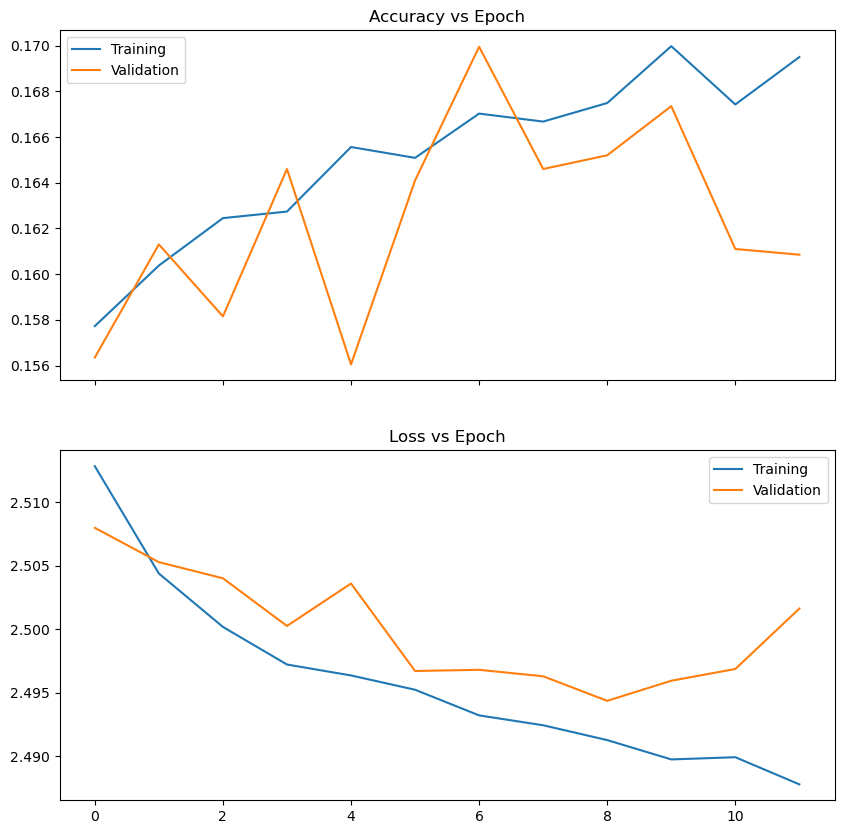

In [28]:
# Model evaluation graphs
fig = plt.figure(figsize=(10,10))
axes = fig.subplots(nrows=2, ncols=1, sharex=True)
axes[0].plot(transformer_res.history['accuracy'])
axes[0].plot(transformer_res.history['val_accuracy'])
#axes[0].set_ylim([0,1.])
axes[0].legend(["Training", "Validation"])
axes[0].set_title("Accuracy vs Epoch")

axes[1].plot(transformer_res.history['loss'])
axes[1].plot(transformer_res.history['val_loss'])
#axes[1].set_ylim([0,1.])
axes[1].legend(["Training", "Validation"])
axes[1].set_title("Loss vs Epoch")

plt.show()

#### Hyperparameter Tuning Analysis  

After performing this analysis, it appears that the sweet spot for epoch valuation at least for our learning rate samples is around 7-8. This seems to be the location where the validation accuracy is bouncing around a core value. This may mean that we need to tune our learning rate back down a little.

## Conclusions  

In this project, I compared a stacked LSTM architecture to a Transformer architecture when using tweets to predict MBTI of the individual writing the tweets.

I found the Transformer architecture to be slightly better in accuracy, 0.17, compared to the LSTM accuracy of 0.16. Both models seemed to perform about the same in terms of run time, completing a 5 epoch training series in about 10 minutes on the hardware I am using.

Some notes about these findings. While the Transformer model did perform better, both results are pretty terrible. They are almost 3 times better than just randomly guessing an indicator, but an accuracy of 0.17 is not something I would want anyone to leverage. Based on the low accuracy of both, it seems that individual tweets are not a particularly great way of gauging an individual's indicator. We may have better results if we were to look at an individuals entire tweet history.

Either way, some other potential improvements could be noted below:
* Better data engineering accounting for slang and style often found in tweets
* More robust tuning of the models potentially requiring better hardware
* Actual MBTI class was captured from tweets noting it. For a stricter experiment we may have individuals take the assessment to determine class

## Sources  

* [Deep Learning with Python, Second Edition](https://learning.oreilly.com/library/view/deep-learning-with/9781617296864/)
* [Transformer Machine Learning Model](https://en.wikipedia.org/wiki/Transformer_(machine_learning_model))
* [MBTI Dataset](https://www.kaggle.com/datasets/mazlumi/mbti-personality-type-twitter-dataset)
* [The Myers & Briggs Foundation](https://www.myersbriggs.org/)